### Global Validation ###

This notebook combines several validation notebooks: `global_validation_tasmax_v2.ipynb` and `global_validation_dtr_v2.ipynb` along with `check_aiqpd_downscaled_data.ipynb` to create a "master" global validation notebook. It also borrows validation code from the ERA-5 workflow, `validate_era5_hourlyORdaily_files.ipynb`. It is intended to be run with `papermill`. 

### Data Sources ###

Coarse Resolution: 
- CMIP6 
- Bias corrected data 
- ERA-5

Fine Resolution: 
- Bias corrected data 
- Downscaled data 
- ERA-5 (fine resolution)
- ERA-5 (coarse resolution resampled to fine resolution) 

### Types of Validation ### 

Basic: 
- maxes, means, mins  
    - CMIP6, bias corrected and downscaled 
    - historical (1995-2014), 2020-2040, 2040-2060, 2060-2080, 2080-2100 
- differences between historical and future time periods for bias corrected and downscaled
- differences between bias corrected and downscaled data 

Variable-specific: 
- GMST
- days over 95 (future-historical difference plots)
- max # of consecutive dry days, highest precip amount over 5-day rolling window

In [1]:
! pip install xclim # we don't have this package on compute.impactlab

In [2]:
%matplotlib inline 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 

from science_validation_manual import *

In [3]:
import dask
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk

In [4]:
client, cluster = rhgk.get_standard_cluster()

In [6]:
cluster.scale(4)

In [7]:
cluster

### Set Validation Parameters ###

In [8]:
from models_QC import QC_models_dict
models_ID_dict = QC_models_dict()
gcm = 'CAMS-CSM1-0'
workflow = models_ID_dict[gcm]

workflow_location = 'archived-workflows' 
variable = 'tasmax'
ssp = 'ssp370' # ssp options: 'ssp126', 'ssp245', 'ssp370', 'ssp585'

# variable options: 'tasmax', 'tasmin', 'dtr', 'pr'
argo_token = ''

In [9]:
manifest = get_manifest(workflow_identifier=workflow, auth_token=argo_token, workflow_location=workflow_location)

In [10]:
data_dict = collect_paths(manifest, gcm, ssp, variable)

In [11]:
# data output types for running validation 
cmip6 = True
bias_corrected = True
downscaled = True
# projection time period options: '2020_2040', '2040_2060', '2060_2080', '2080_2100'
projection_time_period = '2080_2100'

# validation plot options
basic_diagnostics = True

# options: 'mean', 'max', 'min'
basic_diag_type = 'mean'

# historical paths are included in data_dict below (historical and ssp are separate model runs)
historical = True

gmst = True
hot_days = True
difference_plots = True

# options: 'downscaled_minus_biascorrected' , 'change_from_historical'
diff_type = 'change_from_historical'

In [12]:
# we only plot gmst if validation variable is tasmax 
if variable != 'tasmax': 
    gmst = False
    hot_days = False
    warnings.warn("gmst plotting option changed to False since validation variable is not tasmax")

### other data inputs ### 

In [13]:
units = {'tasmax': 'K', 'tasmin': 'K', 'dtr': 'K', 'pr': 'mm'}
if historical:
    years = {'hist': {'start_yr': '1995', 'end_yr': '2014'}, 
                  '2020_2040': {'start_yr': '2020', 'end_yr': '2040'}, 
                  '2040_2060': {'start_yr': '2040', 'end_yr': '2060'}, 
                  '2060_2080': {'start_yr': '2060', 'end_yr': '2080'}, 
                  '2080_2100': {'start_yr': '2080', 'end_yr': '2100'}}
else:
    years = {'2020_2040': {'start_yr': '2020', 'end_yr': '2040'}, 
              '2040_2060': {'start_yr': '2040', 'end_yr': '2060'}, 
              '2060_2080': {'start_yr': '2060', 'end_yr': '2080'}, 
              '2080_2100': {'start_yr': '2080', 'end_yr': '2100'}}
years_test = {'hist': {'start_yr': '1995', 'end_yr': '2014'}, 
              '2020_2040': {'start_yr': '2020', 'end_yr': '2040'}, 
              '2040_2060': {'start_yr': '2040', 'end_yr': '2060'}}

### Validation ### 

### basic diagnostic plots: means, maxes, mins ### 

KilledWorker: ('open_dataset-f66b653b405c8dc1a2a0a06adcb4e537tasmax-56bafacb4a043c65616d3997858f7166', <Worker 'tls://10.23.159.2:43865', name: dask-worker-abfb2306efb9425d870745c37c1355fb-4cn4j, memory: 0, processing: 1>)

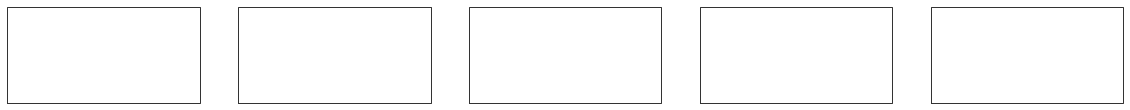

In [14]:
if cmip6 and basic_diagnostics: 
    if historical: 
        plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                                      ssp, years, variable, basic_diag_type, 'cmip6', 
                                      units[variable], ds_hist=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']), 
                                      vmin=280, vmax=320)
    else:
        print("not including historical period in diagnostics")
        plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                                      ssp, years, variable, basic_diag_type, 'cmip6', 
                                      units[variable], 
                                      vmin=280, vmax=320)

In [ ]:
if bias_corrected and basic_diagnostics: 
    if historical: 
        plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['coarse']['bias_corrected'][ssp]), 
                                      ssp, years, variable, basic_diag_type, 'bias_corrected', 
                                      units[variable], ds_hist=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']), 
                                      vmin=280, vmax=320)
    else:
        print("not including historical period in diagnostics")
        plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['coarse']['bias_corrected'][ssp]), 
                                      ssp, years, variable, basic_diag_type, 'bias_corrected', 
                                      units[variable], 
                                      vmin=280, vmax=320)

In [ ]:
if downscaled and basic_diagnostics: 
    if historical: 
        plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                      ssp, years, variable, basic_diag_type, 'downscaled', 
                                      units[variable], ds_hist=read_gcs_zarr(data_dict['fine']['downscaled']['historical']), 
                                      vmin=280, vmax=320)
    else:
        print("not including historical period in diagnostics")
        plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                      ssp, years, variable, basic_diag_type, 'downscaled', 
                                      units[variable], 
                                      vmin=280, vmax=320)

### GMST ### 

In [ ]:
if gmst: 
    if historical:
        plot_gmst_diagnostic(read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                             read_gcs_zarr(data_dict['coarse']['bias_corrected'][ssp]), 
                             variable=variable, ssp=ssp, 
                             ds_hist_cmip6=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']), 
                             ds_hist_bc=read_gcs_zarr(data_dict['coarse']['bias_corrected']['historical']))
    else:
        plot_gmst_diagnostic(read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                             read_gcs_zarr(data_dict['coarse']['bias_corrected'][ssp]), 
                             variable=variable, ssp=ssp)

### Difference plots: bias corrected - downscaled OR historical - future (bias corrected and downscaled data outputs) ###

Note: if doing bias corrected - downscaled, these two cells produce the same figure. If doing historical - future, the first will show differences for bias corrected and the second for downscaled. For the latter option, `historical` must be `True` in the parameters cell and the correct `diff_type` must be set. 

In [ ]:
if bias_corrected and difference_plots:
    if historical:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                                   diff_type, 'bias_corrected', variable, units[variable], years, 
                                                   ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                                   ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                       ssp=ssp, time_period=projection_time_period)
    else:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                                   diff_type, 'bias_corrected', variable, units[variable], years, 
                                                   ssp=ssp, time_period=projection_time_period)

same figure, colorbar not constrained (controlled by optional argument `robust=False`)

In [ ]:
if bias_corrected and difference_plots:
    if historical:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                                   diff_type, 'bias_corrected', variable, units[variable], years, robust=False,
                                                   ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                                   ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                       ssp=ssp, time_period=projection_time_period)
    else:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                                   diff_type, 'bias_corrected', variable, units[variable], years, robust=False,
                                                   ssp=ssp, time_period=projection_time_period)

In [ ]:
if downscaled and difference_plots:
    if historical:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                                   diff_type, 'downscaled', variable, units[variable], years, 
                                                   ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                                   ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                       ssp=ssp, time_period=projection_time_period)
    else:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                                   diff_type, 'downscaled', variable, units[variable], years, 
                                                   ssp=ssp, time_period=projection_time_period)

### Difference plots for days over 95 degrees F using tasmax ###

In [ ]:
if hot_days and cmip6 and difference_plots and historical :
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]),
                                                   read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                                                   'change_from_historical', 'cmip6', variable, 'days with tasmax >= 95F', years, 
                                                   ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                                   ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ds_hist_cmip=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
                                                       ssp=ssp, time_period=projection_time_period, xr_func=xr_conditional_count)

In [ ]:
if hot_days and bias_corrected and difference_plots and historical:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]),
                                                   read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                                                   'change_from_historical', 'bias_corrected', variable, 'days with tasmax >= 95F', years, 
                                                   ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                                   ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ds_hist_cmip=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
                                                       ssp=ssp, time_period=projection_time_period, xr_func=xr_conditional_count)

In [ ]:
if hot_days and downscaled and difference_plots and historical:
        plot_bias_correction_downscale_differences(read_gcs_zarr(data_dict['fine']['bias_corrected'][ssp]), 
                                                   read_gcs_zarr(data_dict['fine']['downscaled'][ssp]),
                                                   read_gcs_zarr(data_dict['coarse']['cmip6'][ssp]), 
                                                   'change_from_historical', 'downscaled', variable, 'days with tasmax >= 95F', years, 
                                                   ds_hist_bc=read_gcs_zarr(data_dict['fine']['bias_corrected']['historical']),
                                                   ds_hist_ds=read_gcs_zarr(data_dict['fine']['downscaled']['historical']),
                                                   ds_hist_cmip=read_gcs_zarr(data_dict['coarse']['cmip6']['historical']),
                                                       ssp=ssp, time_period=projection_time_period, xr_func=xr_conditional_count)

### Precip - dry days ###

In [ ]:
if variable=='pr'
    plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                  ssp, years, variable, basic_diag_type, 'downscaled', 
                                  units[variable], ds_hist=read_gcs_zarr(data_dict['fine']['downscaled']['historical']), 
                                  vmin=0, vmax=200, xr_func=xc_maximum_consecutive_dry_days)

### Precip - accumulated ###

In [ ]:
if variable=='pr'
    plot_diagnostic_climo_periods(read_gcs_zarr(data_dict['fine']['downscaled'][ssp]), 
                                  ssp, years, variable, basic_diag_type, 'downscaled', 
                                  units[variable], ds_hist=read_gcs_zarr(data_dict['fine']['downscaled']['historical']), 
                                  vmin=0, vmax=200, xr_func=xc_maximum_consecutive_dry_days)